In [129]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '3'

# from IPython.display import display, HTML
# display(HTML(
# """
# <a target="_blank" href="https://colab.research.google.com/github/facebookresearch/segment-anything/blob/main/notebooks/predictor_example.ipynb">
#   <img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/>
# </a>
# """
# ))

In [130]:
using_colab = False

In [131]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import cv2

In [132]:
def show_mask(mask, ax, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)
    
def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)   
    
def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0,0,0,0), lw=2))    


In [133]:
image = cv2.imread('images/truck.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image.shape

(1200, 1800, 3)

In [134]:
# image = cv2.imread('images/truck.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)


import skimage.io as skio
from tifffile import imread, imwrite
root_path = r'/data/sunrui/celldata/F0005/'
file_name = r'F0005.tif'

img_raw = skio.imread(root_path + r'/PRE/test.tif',plugin="tifffile")

image = img_raw[303]

In [135]:
image = image.squeeze()

In [136]:
image = cv2.cvtColor(image,cv2.COLOR_GRAY2RGB)
image.shape

(1000, 1000, 3)

In [137]:
image_folder =root_path + r'/01_GT/SAMSEG_test/'
if not os.path.exists(image_folder):
    os.makedirs(image_folder)

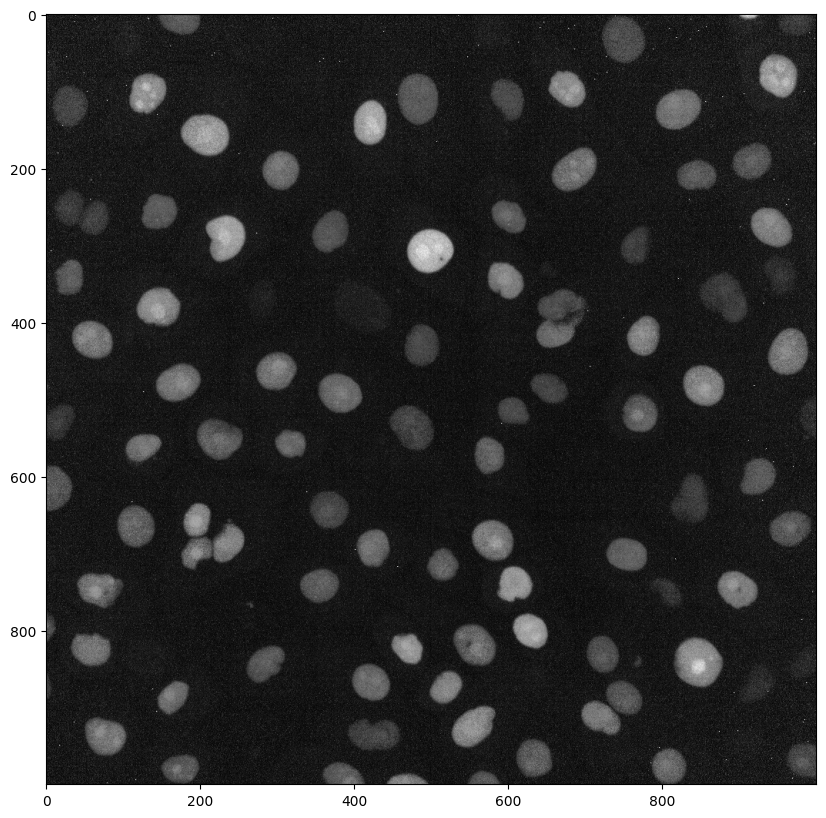

In [138]:
plt.figure(figsize=(10,10))
plt.imshow(image)
plt.axis('on')
plt.show()

In [139]:
import sys
sys.path.append("..")
from segment_anything import sam_model_registry, SamPredictor

sam_checkpoint = "sam_vit_h_4b8939.pth"
model_type = "vit_h"

device = "cuda"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)
sam.to(device=device)

predictor = SamPredictor(sam)

In [140]:
predictor.set_image(image)

In [141]:
# input_point = np.array([[500, 375]])
input_point = np.array([[285, 373],[289,370],[265,375]])
input_label = np.array([1,1,1])

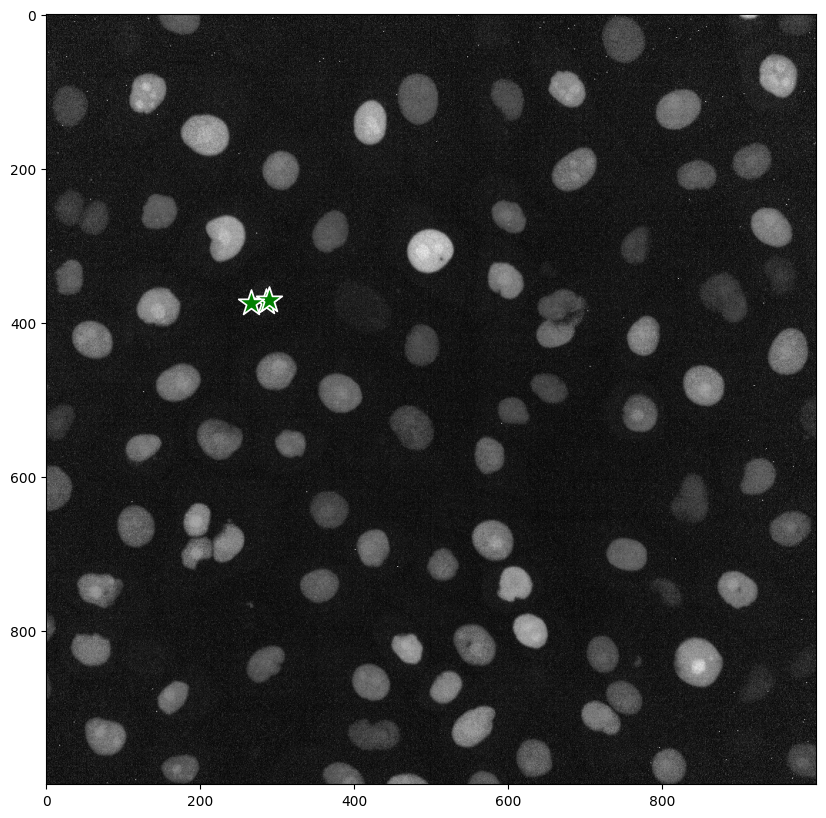

In [142]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()  

In [143]:
masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True,
)

In [144]:
masks.shape  # (number_of_masks) x H x W

(3, 1000, 1000)

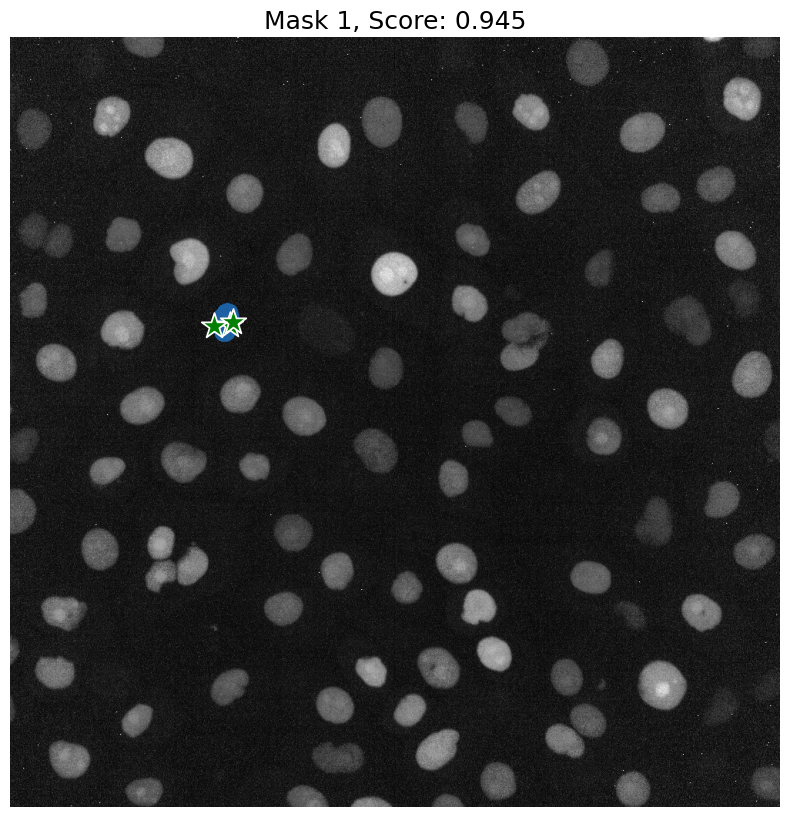

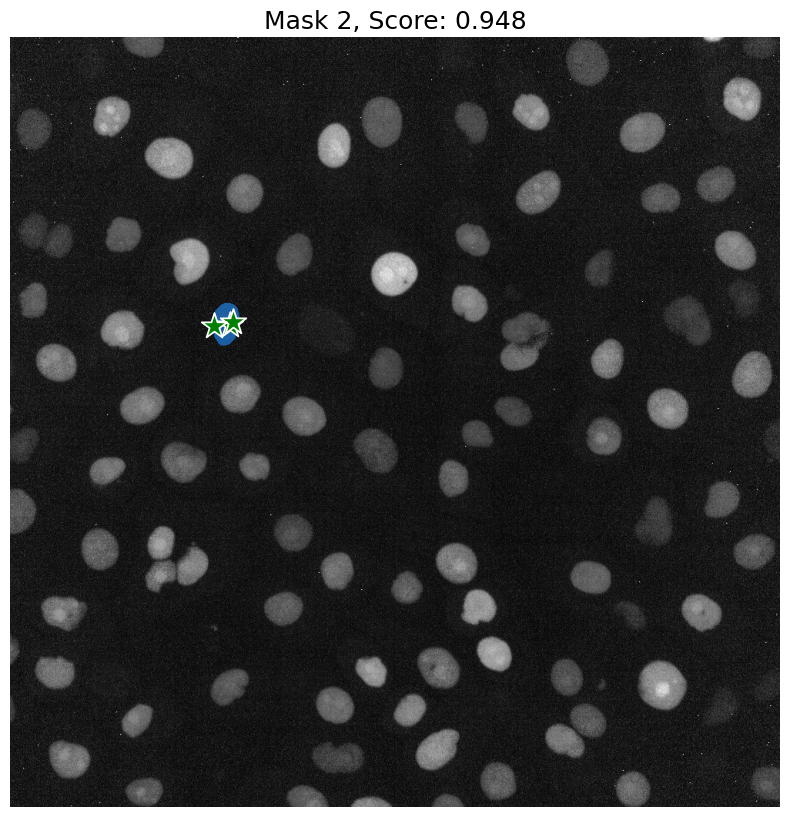

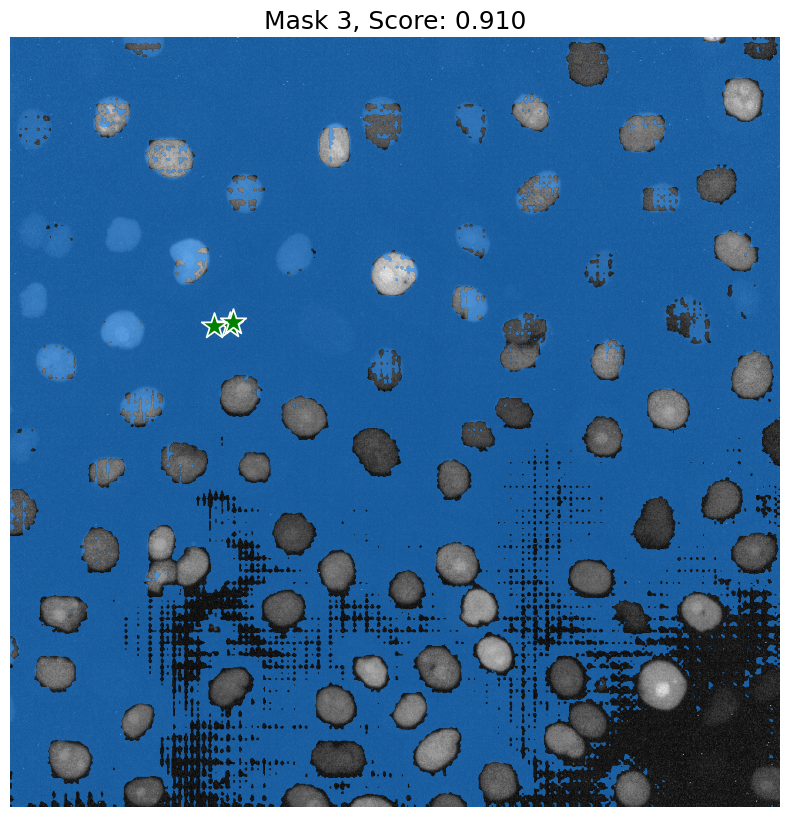

In [145]:
for i, (mask, score) in enumerate(zip(masks, scores)):
    plt.figure(figsize=(10,10))
    plt.imshow(image)
    show_mask(mask, plt.gca())
    show_points(input_point, input_label, plt.gca())
    plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
    plt.axis('off')
    plt.show()  
  

In [146]:
mask_input = logits[np.argmax(scores), :, :] 

In [147]:
masks, _, _ = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    mask_input=mask_input[None, :, :],
    multimask_output=False,
)

In [148]:
masks.shape

(1, 1000, 1000)

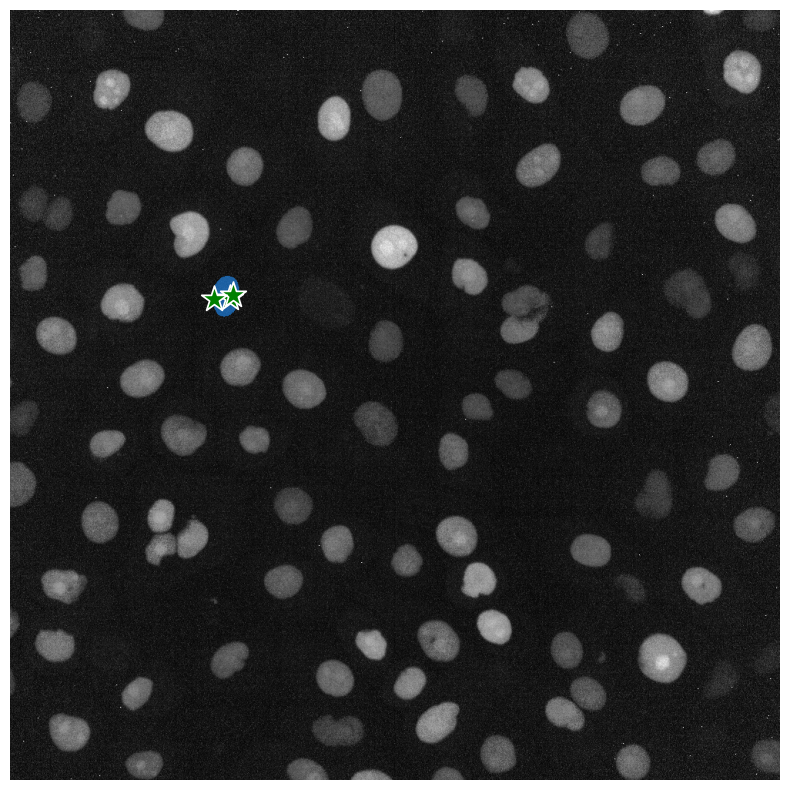

In [149]:
plt.figure(figsize=(10,10))
plt.imshow(image)
show_mask(masks, plt.gca())
show_points(input_point, input_label, plt.gca())
plt.axis('off')
plt.show() 

In [150]:
input_boxes = torch.tensor([
    [75, 275, 1725, 850],
    [425, 600, 700, 875],
    [1375, 550, 1650, 800],
    [1240, 675, 1400, 750],
], device=predictor.device)

input_points = torch.tensor([
    [[285, 373]],
    [[285, 375]],
    [[777, 518]]
    # [[289, 370],[289, 370]],
],device=predictor.device)

input_label = torch.tensor([[1],[1],[1]])

print(input_boxes.shape)
print(input_points.shape)
print(input_label.shape)

torch.Size([4, 4])
torch.Size([3, 1, 2])
torch.Size([3, 1])


In [157]:
input_points = torch.tensor([
    [[285, 373]],
    [[285, 375]],
    [[777, 518]]
],device=predictor.device)

input_label = torch.tensor([[1],[1],[1]])

print(input_points.shape)
print(input_label.shape)

# x1 =torch.tensor([[[168,132]]],device=predictor.device)
# input_points = torch.cat((input_points, x1), dim=0)

# points_all = [[111,223]]

# print(points_all)
# x1 = [111,121]

# points_all.append(x1)

# print(points_all)

# input_points = torch.tensor(points_all,device=predictor.device)
# print(input_points.shape)
# # print(x1.shape)

torch.Size([3, 1, 2])
torch.Size([3, 1])


In [158]:
# 定义三维列表的维度
depth = 3
rows = 4
cols = 5

# 生成一个空的三维列表
empty_3d_list = [[[None for _ in range(cols)] for _ in range(rows)] for _ in range(depth)]

# 可选：将空列表转换为 NumPy 数组或其他数据结构
import numpy as np

empty_3d_array = np.array(empty_3d_list)

# 打印结果
print(empty_3d_list)
print(empty_3d_array)


[[[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]], [[None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None], [None, None, None, None, None]]]
[[[None None None None None]
  [None None None None None]
  [None None None None None]
  [None None None None None]]

 [[None None None None None]
  [None None None None None]
  [None None None None None]
  [None None None None None]]

 [[None None None None None]
  [None None None None None]
  [None None None None None]
  [None None None None None]]]


In [159]:
transformed_coords = predictor.transform.apply_coords_torch(input_points, image.shape[:2])
# input_label = torch.tensor([1,1])

In [160]:
predictor.set_image(image)
masks, _, _ = predictor.predict_torch(
    point_coords=transformed_coords,
    point_labels=input_label,
    boxes=None,
    multimask_output=False,
)

In [161]:
masks.shape  # (batch_size) x (num_predicted_masks_per_input) x H x W
print(masks)

tensor([[[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False]]],


        [[[False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          [False, False, False,  ..., False, False, False],
          ...,
          [False, False, False,  ..., False, Fa

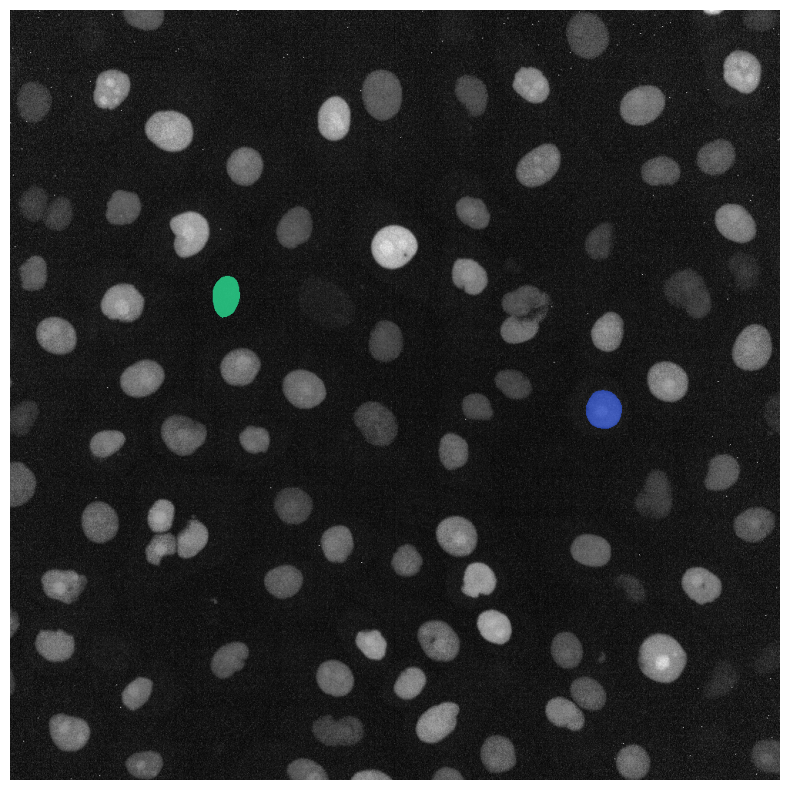

In [162]:
plt.figure(figsize=(10, 10))
plt.imshow(image)
for mask in masks:
    show_mask(mask.cpu().numpy(), plt.gca(), random_color=True)
# for box in input_boxes:
#     show_box(box.cpu().numpy(), plt.gca())
plt.axis('off')
plt.show()

In [164]:
print(masks.shape)

torch.Size([3, 1, 1000, 1000])


: 